# Data Science Internship Assesment

Here is the method I used to predict the consumption of water and detect possible leaks.

I am going to use Facebook's libeary Prophet which is very usefull for timestamped data frames such as the one I am working with. Lets import all the libraries necessary for the task

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import datetime
import itertools
import numpy as np
from sklearn import preprocessing

Importing plotly failed. Interactive plots will not work.


A quick vue of the data frame tells me that at a lot of time, the pulse is equal to zero, which means that no water is used. I saw 2 possible option for a leak. 

1) There is a constant leak increasing the consumption at all time

2) A certain home appliance machine is leaking when used which will increase the consumption during a certain time but won't change anyhting when unused


## 1) Prediction

In [2]:
data = pd.read_csv('data_scientist_intern_assessment.csv')
data 

,timestamp,pulses
0,2019-12-25 11:10:17,0
1,2019-12-25 11:16:17,0
2,2019-12-25 11:22:17,0
3,2019-12-25 11:28:20,0
4,2019-12-25 11:34:20,0
...,...,...
85587,2020-12-23 09:59:22,20
85588,2020-12-23 10:05:22,9
85589,2020-12-23 10:11:22,0
85590,2020-12-23 10:17:22,12


In [3]:
data['pulses'].mean() #Lets get the mean to see what is the average consumption 

7.169139639218619

In [4]:
data['pulses'].max() #The max is useful to understand high values and see if a standardize 

272

In [5]:
print(f"The number of 0 consumption is {data['pulses'].isin([0]).sum()}") 

The number of 0 consumption is 49529


This stroke me first. We can see that during the big majority of the time (almost 60%) no water is used. It will have a big impact on the data because we see that the max is 272 pulses and the mean of 7.2 pulses. We don't want those big numbers to influence too much. In order to back my observation I ploted the first 1001 values to see how the data looked. 

In [6]:
data_short = data.loc[0:1000]

In [7]:
print(f"The number of 0 consumption is {data_short['pulses'].isin([0]).sum() }") 

The number of 0 consumption is 816


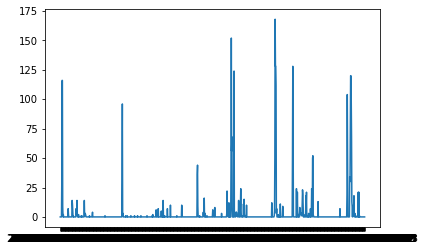

In [8]:
plt.plot(data_short['timestamp'], data_short['pulses'])
plt.show()

We can see that it is a bit chaotic and that here 82% of the time, the consumption is 0. This means that I have the standardize the data to bring everything back between 0 and 1. 

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
pulses = data['pulses'].values

std_pulses = min_max_scaler.fit_transform(pulses.reshape(-1, 1))
data['pulses'] = std_pulses

Then, I will change a bit the data set to make it readable by Prophet.

In [10]:
data.columns = ['ds', 'y'] #Prophet needs the columns to be named ds and y 

In [11]:
m = Prophet(yearly_seasonality=False,
                  weekly_seasonality=True, changepoint_prior_scale=.2) #Deactivated yearly_seasonality and activated weekly to prefer this last over the year one
m.fit(data)
future = m.make_future_dataframe(periods=672, freq='H') #Complete the timestamp hour per hour
future.tail()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,ds
86259,2021-01-20 06:23:22
86260,2021-01-20 07:23:22
86261,2021-01-20 08:23:22
86262,2021-01-20 09:23:22
86263,2021-01-20 10:23:22


Lets make a forecast for Janurary 2021. 

In [12]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
86259,2021-01-20 06:23:22,0.028915,-0.050964,0.120296,0.016180,0.039829,0.003672,0.003672,0.003672,0.002245,0.002245,0.002245,0.001426,0.001426,0.001426,0.0,0.0,0.0,0.032586
86260,2021-01-20 07:23:22,0.028916,-0.043037,0.123894,0.016136,0.039849,0.013416,0.013416,0.013416,0.011795,0.011795,0.011795,0.001621,0.001621,0.001621,0.0,0.0,0.0,0.042332
86261,2021-01-20 08:23:22,0.028917,-0.033419,0.128304,0.016092,0.039869,0.018820,0.018820,0.018820,0.017015,0.017015,0.017015,0.001806,0.001806,0.001806,0.0,0.0,0.0,0.047737
86262,2021-01-20 09:23:22,0.028918,-0.036014,0.130166,0.016047,0.039889,0.018672,0.018672,0.018672,0.016694,0.016694,0.016694,0.001978,0.001978,0.001978,0.0,0.0,0.0,0.047590
86263,2021-01-20 10:23:22,0.028920,-0.041955,0.126248,0.015998,0.039908,0.013911,0.013911,0.013911,0.011773,0.011773,0.011773,0.002138,0.002138,0.002138,0.0,0.0,0.0,0.042831


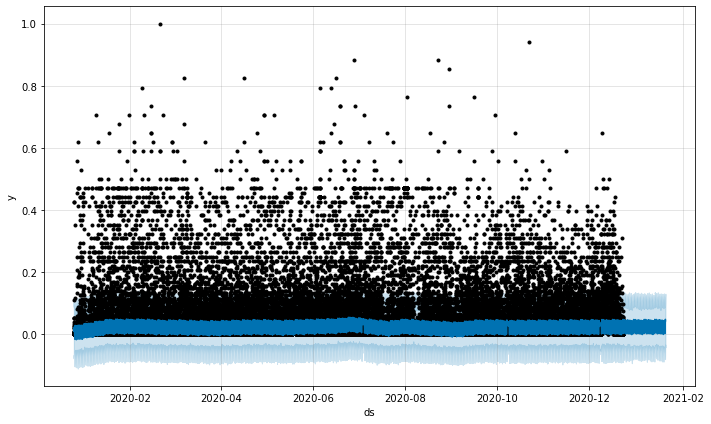

In [13]:
fig1 = m.plot(forecast) 

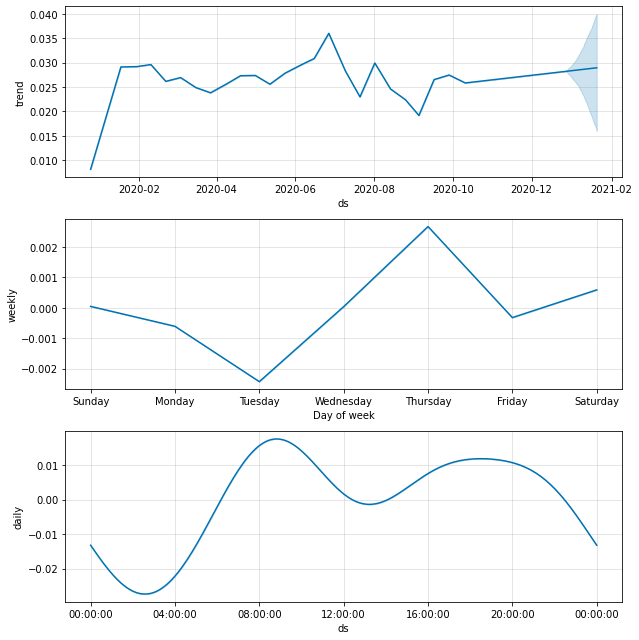

In [14]:
fig2 = m.plot_components(forecast) 

This is a first try forecast and it might not be optimal. In order to know how to tune the algorithm, I will procede with a corssvalidation based on the change_prior_scale and seasonality_prior_scale to select the best hyperparmeters. We will use the RMSE. We also need to avoid overfitting in case the changepoint prior scale is too high

In [18]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  
for params in all_params:
    m = Prophet(**params).fit(data)  
    data_cv = cross_validation(m, horizon='30 days')
    data_p = performance_metrics(data_cv, rolling_window=1)
    rmses.append(data_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-03-28 10:23:22 and 2020-11-23 10:23:22
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-03-28 10:23:22 and 2020-11-23 10:23:22
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-03-28 10:23:22 and 2020-11-23 10:23:22
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-03-28 10:23:22 and 2020-11-23 10:23:22
INFO:fbprophet:Skipping MAPE becau

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.065217
1                     0.001                     0.10  0.065215
2                     0.001                     1.00  0.065216
3                     0.010                     0.01  0.065272
4                     0.010                     0.10  0.065271
5                     0.010                     1.00  0.065268
6                     0.100                     0.01  0.065383
7                     0.100                     0.10  0.065378
8                     0.100                     1.00  0.065383
9                     0.500                     0.01  0.065406
10                    0.500                     0.10  0.065403
11                    0.500                     1.00  0.065409


The results of the RMSE show that it is better to choose the following hyperparameters. 
Now lets train and see the results of the algorithm:

In [205]:
m = Prophet(yearly_seasonality=False,
                  weekly_seasonality=True, changepoint_prior_scale=.001, seasonality_prior_scale = 0.1)
m.fit(data)
future = m.make_future_dataframe(periods = 612, freq = 'H')
future.tail()

,ds
86199,2021-01-17 18:23:22
86200,2021-01-17 19:23:22
86201,2021-01-17 20:23:22
86202,2021-01-17 21:23:22
86203,2021-01-17 22:23:22


In [206]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
86199,2021-01-17 18:23:22,0.037609,-0.042292,0.125973
86200,2021-01-17 19:23:22,0.037241,-0.048919,0.114898
86201,2021-01-17 20:23:22,0.035715,-0.049522,0.124336
86202,2021-01-17 21:23:22,0.032283,-0.056261,0.116709
86203,2021-01-17 22:23:22,0.026255,-0.056042,0.115241


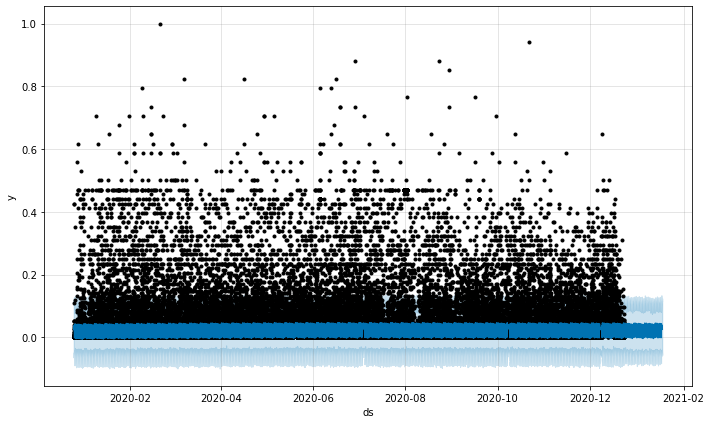

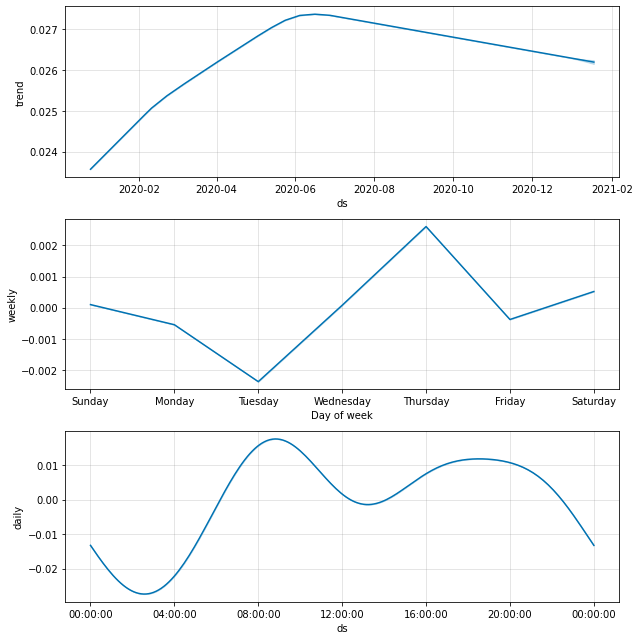

In [207]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

__Observation__: The results are indeed much better with a confidence interval much smaller than before. However, maybe that taking the whole year as a base for our prediction is not a good idea. We might need to only take the last month and see what it does. 

In [208]:
data_month = data[78762:]
data_month

,ds,y
78762,2020-11-23 10:24:20,0.003676
78763,2020-11-23 10:30:20,0.022059
78764,2020-11-23 10:36:20,0.003676
78765,2020-11-23 10:42:20,0.003676
78766,2020-11-23 10:48:20,0.003676
...,...,...
85587,2020-12-23 09:59:22,0.073529
85588,2020-12-23 10:05:22,0.033088
85589,2020-12-23 10:11:22,0.000000
85590,2020-12-23 10:17:22,0.044118


In [209]:
m = Prophet(yearly_seasonality=False,
                  weekly_seasonality=True, changepoint_prior_scale=.001, seasonality_prior_scale = 0.1)
m.fit(data_trimestre)

future = m.make_future_dataframe(periods=300, freq='H')
future.tail()

,ds
7125,2021-01-04 18:23:22
7126,2021-01-04 19:23:22
7127,2021-01-04 20:23:22
7128,2021-01-04 21:23:22
7129,2021-01-04 22:23:22


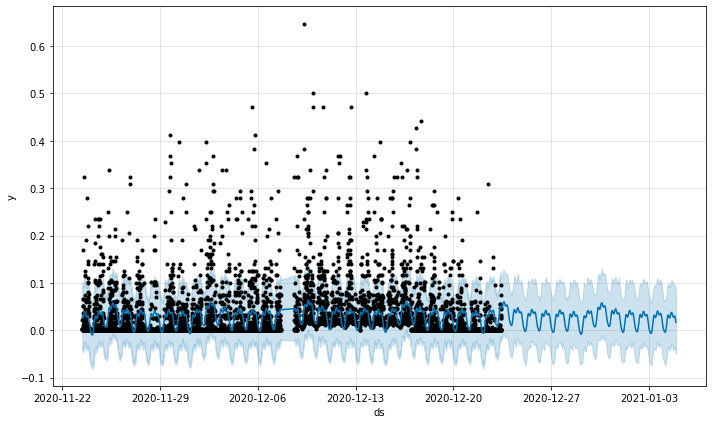

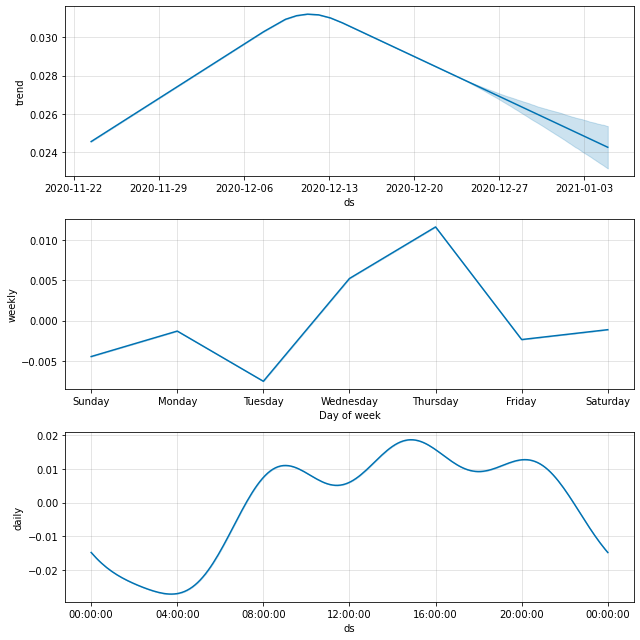

In [210]:
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

The results show the periodicity in terms of consumption. They are also very close to what we have before and the error range seems reasonable. The results can now be use for leaks detection

## 2) Detection of leaks

As explained before, we can see that the majority of the time, water consumption is 0. Therefore, based on the 2 possible leaks I have highlighted, the constant one and the one due to a machine, it is necessary to check if one of those leaks is happening. To do that, two verifications are needed:

1) Calculate the consumption of the predicted forecast and compare it with the real one, if it is higher than a certain limit, alert that the water consumption is unsual and a leak is possible

2) See if the amount of time water is not consumed corresponds to the predicted one. If not, a leak could be occuring

3) We can also take a look at the periodicity of the consumption. A leak will change this periodicity and create irregularities which can be compared to past oscillation. This could also be use as a confirmation for any possible leaks detected.